In [1]:
%matplotlib inline

In [2]:
from fenics import *
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dolfin.fem.norms as norms

import modules_tracking as modules

## Projected gradient method
1) Initialize $q_0 \in \mathcal{Q}_{ad}$, set $k = 0$ 

2) Compute $u_k, p_k$ as solutions to (SE) and (AE) respectively

3) Define $\nu_k := - j'(q_k)$

4) Compute step length $s_k$, e.g. using the Armijo condition:     $$j(q_k + s_k \nu_k) = \min_{s > 0} j(q_k + s \nu_k)$$
    
5) Set $q_{k+1} = \mathcal{P}_{[q_a, q_b]} \{q_k + s_k \nu_k \}$


In [3]:
# --- Define mesh and function space ---

# Set time parameters
T = 4.0
num_steps = 200
dt = T/num_steps

# Define function space
nx = 64
ny = 64
mesh = UnitSquareMesh(nx,ny)
V = FunctionSpace(mesh, 'CG', 1)

# --- Specify parameters ---

element = FiniteElement("CG", triangle, 1)

q_min = 0.0
q_max = 1.0

params_old = {
    "rho": 5.0,
    "lambda_": 10.0,
    "r": 2.0,
    "alpha": 15.0,
    "a": Constant(10)
}

a0 = 1.0
a1 = 1e-01
a_tol = 1e-14
# a_exp = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a0 : a1', element=element, a0=a0, a1=a1, tol=a_tol)
# a_exp = Expression('1.4*exp(-(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)))', element=element)
a_exp = Constant(1.0)
a_const = interpolate(a_exp, V)
alpha = 1e-05
params = {
    "alpha": alpha,
    "a": a_const
}

# rho = 5.0
# lambda_ = 10.0
# r = 2.0
# alpha = 15.0
# a = Constant(10)

In [4]:
q_pre = Expression('exp(-pow(x[0] - 0.5, 2) - pow(x[1] - 0.5, 2))', element=element, t=0)
Q_pre = [interpolate(q_pre, V)]

time = 0
for i in range(num_steps):
    time += dt
    q_pre.t = time
    Q_pre.append(interpolate(q_pre, V))
Q_pre = np.asarray(Q_pre)

u_0_pre = Constant(0.7)
u_n_pre = interpolate(u_0_pre, V)

u_d = modules.solve_state_eq(u_n_pre, Q_pre, V, T, num_steps, params)

In [5]:
params["u_d"] = u_d

In [6]:
# --- Initialization ---

# State
u_0 = Constant(0.7)  # Expression('b*exp(-a*(pow(x[0]-0.25, 2) + pow(x[1]-0.25, 2)))', degree=2, a=10, b=20)
u_n = interpolate(u_0, V)

# Control
str1 = 'b*exp(-a*pow(x[0] - (0.5 - 0.25*sin(3.14*t)), 2) - a*pow(x[1] - (0.5 - 0.25*cos(3.14*t)), 2)) + '
str2 = 'b*exp(-a*pow(x[0] - (0.5 + 0.25*sin(3.14*t)), 2) - a*pow(x[1] - (0.5 + 0.25*cos(3.14*t)), 2))'
string = str1 + str2

q = Constant((float(q_max)-float(q_min))/2)   # Expression(string, degree=2, a=50, b=10, t=0)
# q = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a1 : a0', element=element, a0=a0, a1=a1, tol=a_tol)
# q = Expression('exp(-pow(x[0] - 0.5, 2) - pow(x[1] - 0.5, 2))', element=element, t=0)
t = 0
Q = [interpolate(q, V)]
for i in range(num_steps):
    t += dt
    q.t = t
    Q.append(interpolate(q, V))
Q = np.asarray(Q)


# Adjoint variable
p_end = Constant(0)
p_n = interpolate(p_end, V)

In [7]:
# --- Projected gradient loop ---


tol = 1e-03
f_tol = 1e-05
v_k = 1
v_k_norm = 1

U_initial = modules.solve_state_eq(u_n, Q, V, T, num_steps, params)

j_prev = 0
j_curr = modules.j(U_initial, Q, mesh, T, num_steps, params)
diff = abs(j_prev - j_curr)

print("Initial objective function value: {} \n".format(j_curr))

it = 0
while v_k_norm > tol and diff > f_tol:
    it += 1
    
    j_prev = j_curr
    
    U = modules.solve_state_eq(u_n, Q, V, T, num_steps, params)
    P = modules.solve_adjoint_eq(p_n, U, Q, V, T, num_steps, params)
    v_k = -1*modules.dj(U, Q, P, T, num_steps, params)
    [s_k, j_curr, armijo_it] = modules.armijo(v_k, U, Q, P, V, mesh, T, num_steps, params, u_0)
    diff = abs(j_prev - j_curr)
    
    Q = Q + s_k*v_k
    Q = modules.project_to_admissible(Q, q_min, q_max, V)
    
    v_k_norm = modules.grad_norm(v_k, V, T, num_steps)
    
    modules.pg_print(j_curr, j_prev, v_k_norm, it, armijo_it, s_k)


Cost Functional Data
I1: 0.14749713621441704
I3: 5.000000000000001e-06

Initial objective function value: 0.14750213621441705 

Cost Functional Data
I1: 0.14749713621441704
I3: 5.000000000000001e-06

Cost Functional Data
I1: 0.03579296808724335
I3: 1.4307328421259742e-05

-----------------------------------
Projected gradient iteration no. 1 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: 0.03580727541566461
Decrease in function value: 0.11169486079875243
Norm of gradient: 0.7328118188889747
-----------------------------------

Cost Functional Data
I1: 0.01569415527774553
I3: 1.4025675538011266e-05

Cost Functional Data
I1: 0.24054972496851887
I3: 9.035999133077206e-06

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Cost Functional Data
I1: 0.019682829167305724
I3: 1.1297331630147719e-05

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling

In [ ]:
foo = project(Q[i], V)

In [ ]:
lst = np.zeros(100)

In [ ]:
lst[0] = Function(V)

In [ ]:
foo.vector() > 0.0

In [8]:
U = modules.solve_state_eq(u_n, Q, V, T, num_steps, params)
P = modules.solve_adjoint_eq(p_n, U, Q, V, T, num_steps, params)

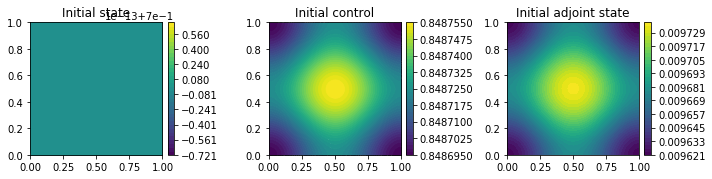

Umax = 0.7
Umin = 0.7


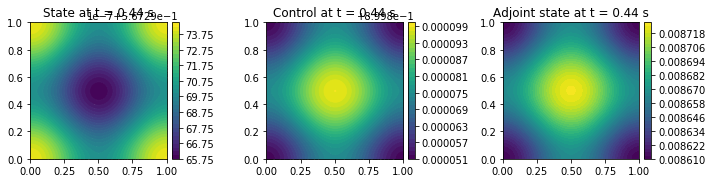

Umax = 0.5672974264001762
Umin = 0.5672965807896785


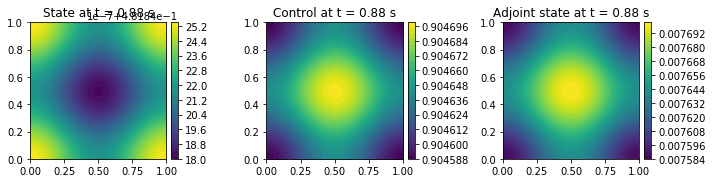

Umax = 0.4818425341118483
Umin = 0.4818418142813921


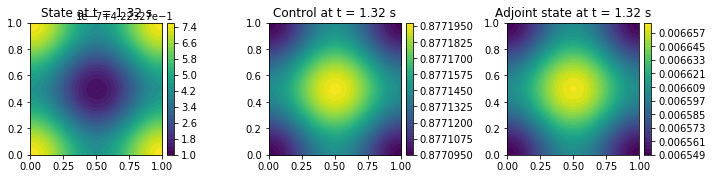

Umax = 0.42232775123163957
Umin = 0.4223271193389111


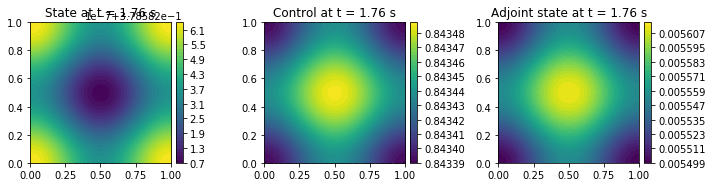

Umax = 0.3785826395074107
Umin = 0.3785820724275659


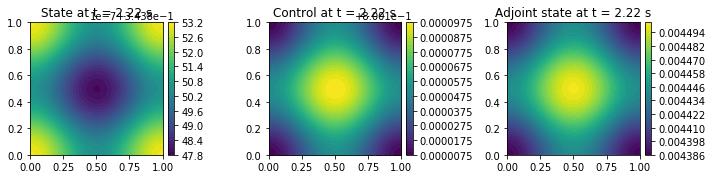

Umax = 0.34380530765913464
Umin = 0.34380479221162613


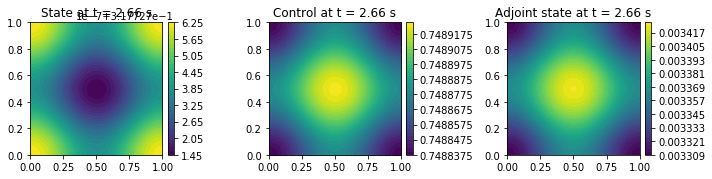

Umax = 0.3177276219409349
Umin = 0.31772714527133716


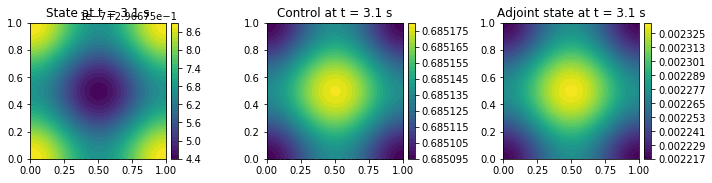

Umax = 0.2966758896216543
Umin = 0.2966754442943278


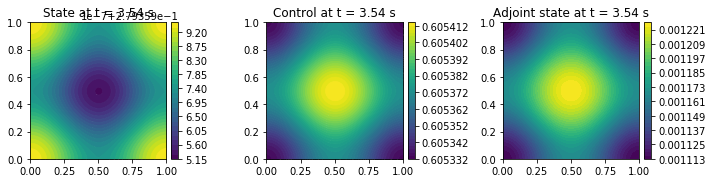

Umax = 0.27935994758813054
Umin = 0.27935952806673964


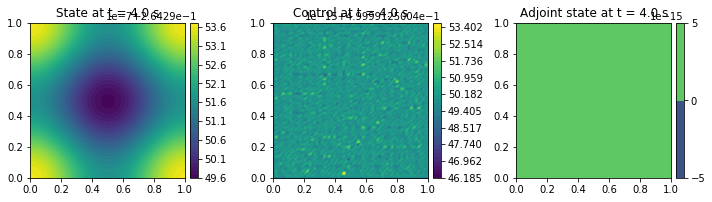

Umax = 0.2642953621620095
Umin = 0.26429496511024364


In [9]:
qmin = float(q_min)
qmax = float(q_max)
levels = np.linspace(qmin, qmax, 100)
kw_q = dict(levels=levels, vmin=qmin, vmax=qmax)
modules.plot_states_and_control(U, Q, P, T, num_steps, num_plots=10)

In [ ]:
for id in [10 * i for i in range(1, 11)]:
    print(Q[id].vector().min())
    print(Q[id].vector().max())
    
    print()

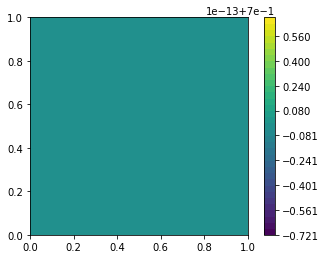

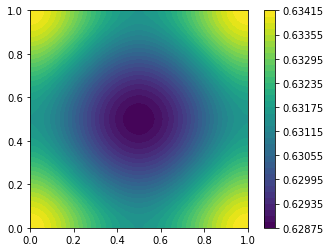

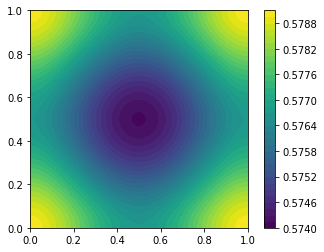

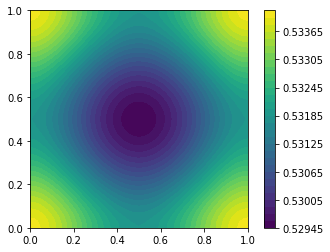

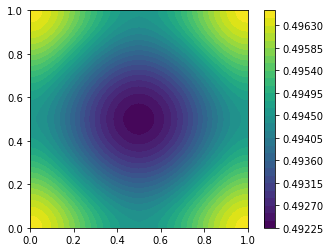

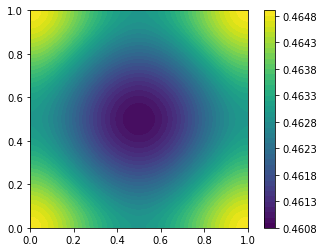

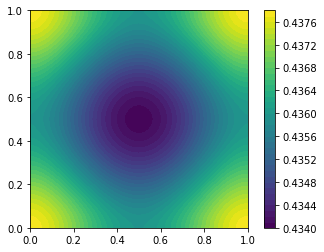

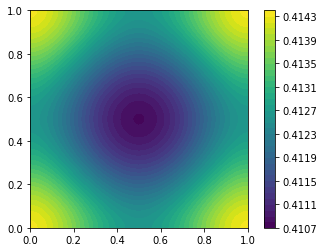

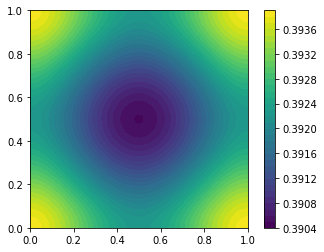

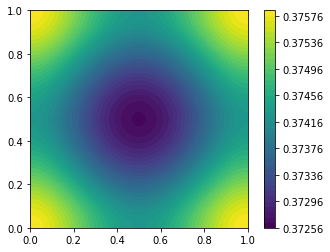

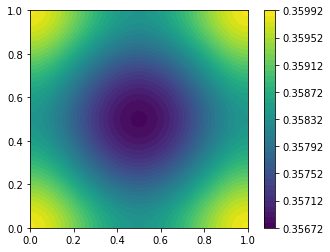

In [10]:
ids = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i in ids:
    pd = plot(u_d[i])
    plt.colorbar(pd)
    plt.show()

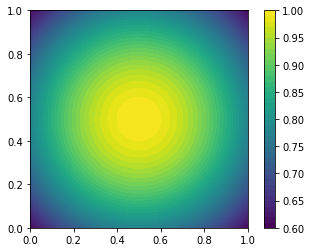

In [11]:
pq = plot(Q_pre[0])
plt.colorbar(pq)
plt.show()

In [ ]:
float(q)

In [ ]:
plut = plot(a_const)
plt.colorbar(plut)
plt.show()

In [ ]:
n_ = 80
mesh_ = UnitIntervalMesh(n_)
space = FunctionSpace(mesh_, 'P', 1)

element_ = FiniteElement('P', triangle, 1)

func = Expression('pow(x[0] - 0.5, 2) - 0.15', degree=2)
f = project(func, space)

plot(f)

In [ ]:
f.vector() < -0.10

In [ ]:
f.vector()[f.vector() < -0.10]

In [ ]:
F = [f]
F = modules.project_to_admissible(F, -0.10, 0.00, space)
plot(F[0])

In [ ]:
Q_test = []
U_test = []

q_test = Expression('exp(x[0]) + pow(t, 2)', element=element, t=0)
u_test = Expression('x[0]*x[1]*t', element=element, t=0)

t = 0
dt = T/num_steps

for i in range(num_steps + 1):
    Q_test.append(project(q_test, V))
    U_test.append(project(u_test, V))
    
    t += dt
    q_test.t = t
    u_test.t = t

In [ ]:
res = modules.j(U_test, Q_test, mesh, T, num_steps, params)

In [ ]:
res

In [ ]:
lambda_

In [ ]:
alpha

In [ ]:
q0 = 10.0
q1 = 1e-01
q_tol = 1e-14
q_exp = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a0 : a1', element=element, a0=q0, a1=q1, tol=q_tol)
Q_trial = []

for i in range(num_steps + 1):
    Q_trial.append(project(q_exp, V))
    
U_trial = modules.solve_state_eq(u_0, Q_trial, V, T, num_steps, params)
P_trial = modules.solve_adjoint_eq(p_end, U_trial, Q, V, T, num_steps, params)

In [ ]:
modules.plot_states_and_control(U_trial, Q_trial, P_trial, T, num_steps, 5)